### PID control

In [1]:
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r,r2rpy
from pip import PID_ControllerClass
from scipy.spatial.distance import cdist
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Parse `Panda`

In [2]:
xml_path = '../model/panda/franka_panda.xml'
env = MuJoCoParserClass(name='Panda',rel_xml_path=xml_path,VERBOSE=True)
print ("[Panda] parsed.")

n_body:[26]
geom_names:['ground', 'pedestal_vis', 'panda_link_0_visual', 'panda_link_0_collision', 'panda_link_1_visual', 'panda_link_1_collision', 'panda_link_2_visual', 'panda_link_2_collision', 'panda_link_3_visual', 'panda_link_3_collision', 'panda_link_4_visual', 'panda_link_4_collision', 'panda_link_5_visual', 'panda_link_5_collision', 'panda_link_6_visual', 'panda_link_6_collision', 'panda_link_7_visual', 'panda_link_7_collision', 'panda_hand_visual', 'panda_hand_collision', 'panda_finger1_visual', 'panda_finger1_collision', 'panda_finger1_pad_collision', 'panda_finger2_visual', 'panda_finger2_collision', 'panda_finger2_pad_collision']
n_body:[18]
body_names:['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_link_6', 'panda_link_7', 'right_hand', 'panda_right_gripper', 'panda_eef', 'panda_leftfinger', 'panda_finger_joint1_tip', 'panda_rightfinger', 'panda_finger_joint2_tip']
n_joint:[9]

In [3]:
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 1000.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.ctrl_ranges[env.rev_joint_idxs,0],
    out_max = env.ctrl_ranges[env.rev_joint_idxs,1],
    ANTIWU  = True)
print ("[%s] ready."%(PID.name))

[PID] ready.


In [4]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_TRANSPARENT=True) # transparent
env.reset()
PID.reset()
# Desired joint position targets for PID control
q_des1 = np.array([0,0,0,-90,0,90,0])*np.pi/180.0
q_des2 = np.array([0,0,-90,0,90,90,0])*np.pi/180.0
q_des3 = np.array([0,0,90,-90,0,90,0])*np.pi/180.0
# Buffers
max_tick    = 3000
sec_list    = np.zeros(shape=max_tick)
q_list      = np.zeros(shape=(max_tick,env.n_rev_joint))
q_des_list  = np.zeros(shape=(max_tick,PID.dim))
torque_list = np.zeros(shape=(max_tick,env.n_rev_joint))
while env.tick < max_tick:
    if (env.tick/max_tick) < 1/3: q_des = q_des1
    elif (env.tick/max_tick) < 2/3: q_des = q_des2
    else: q_des = q_des3
    # PID control
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sim_time(),
               x_curr=env.get_q(joint_idxs=env.rev_joint_idxs),VERBOSE=False)
    torque = PID.out()
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    if (env.tick % 10) == 0:
        env.render()
    # Append
    sec_list[env.tick-1]      = env.get_sim_time()
    q_list[env.tick-1,:]      = env.get_q(joint_idxs=env.rev_joint_idxs)
    q_des_list[env.tick-1,:]  = q_des
    torque_list[env.tick-1,:] = torque
env.close_viewer()    
print ("Done.")

Done.


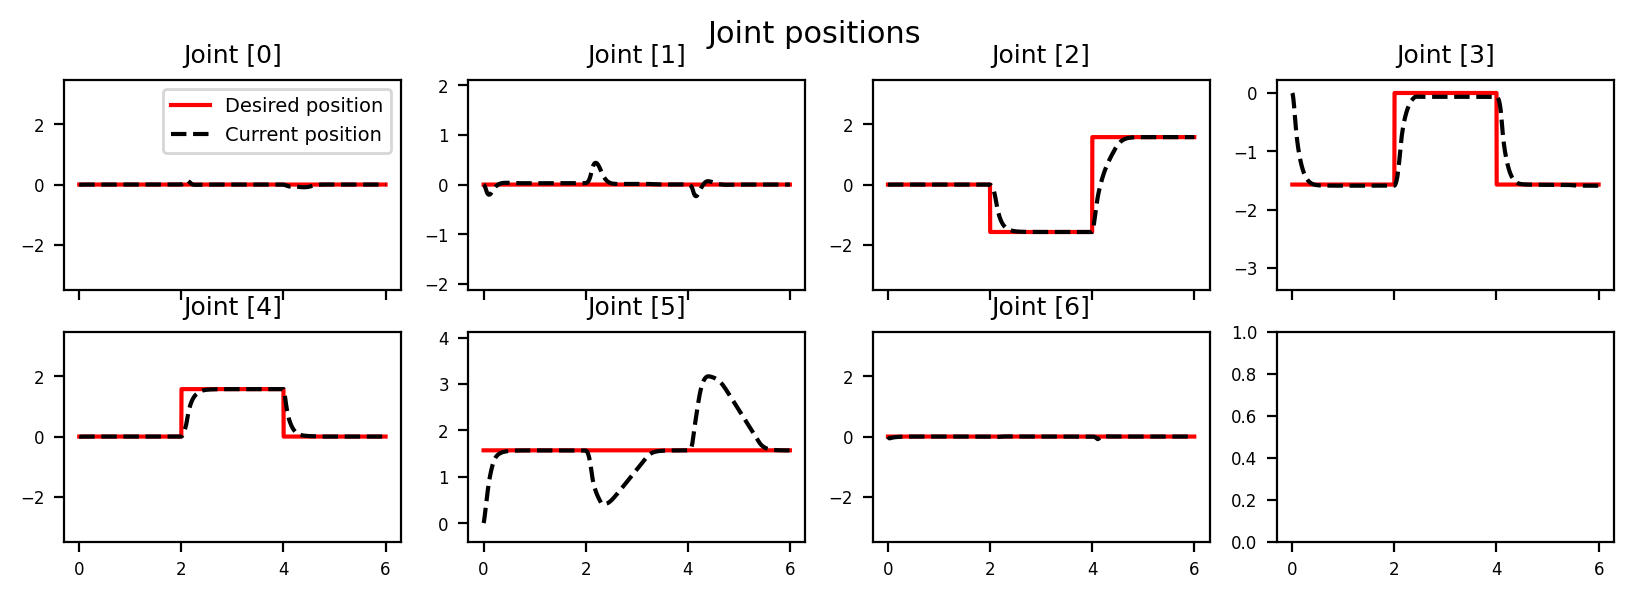

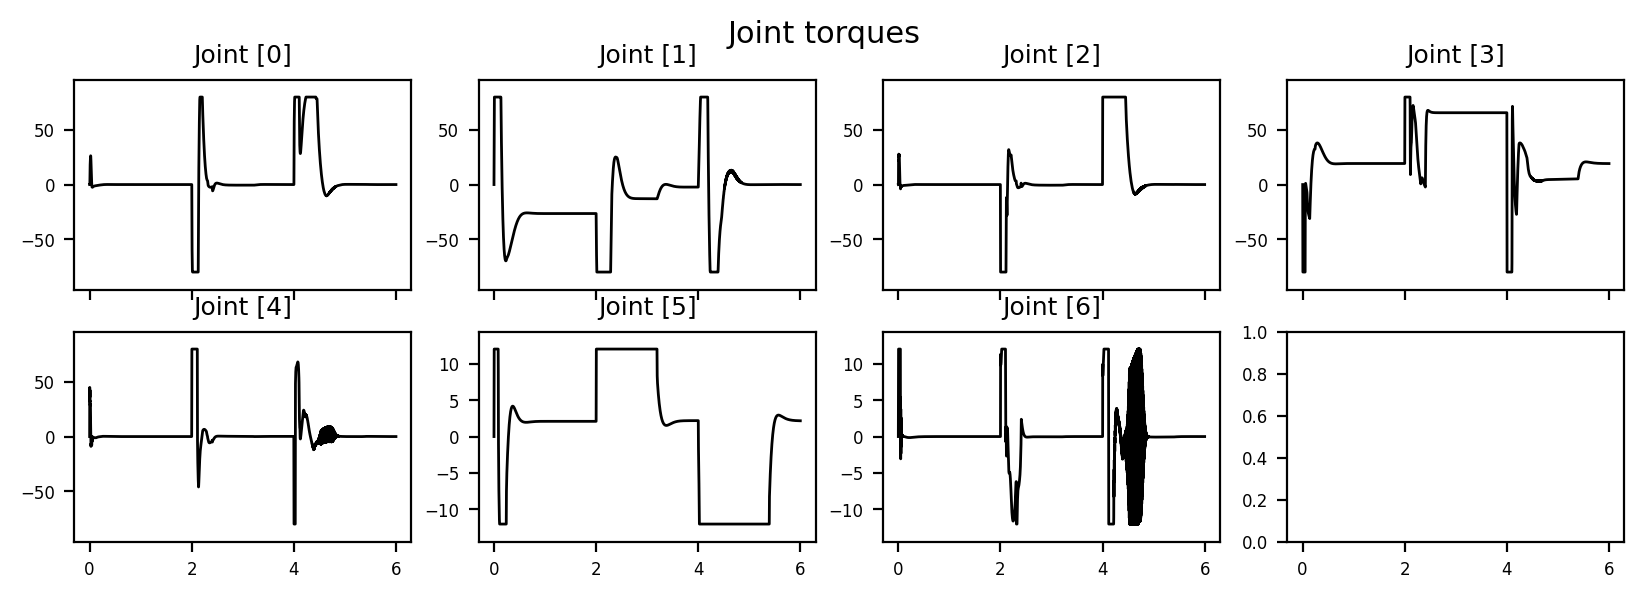

In [5]:
# Plot joint positions
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(10,3))
fig.suptitle("Joint positions", fontsize=11)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_list,q_des_list[:,a_idx],'-',color='r',label='Desired position')
    ax.plot(sec_list,q_list[:,a_idx],'--',color='k',label='Current position')
    qmarg = 0.1*(env.joint_ranges[a_idx,1]-env.joint_ranges[a_idx,0])
    ax.set_ylim(bottom=env.joint_ranges[a_idx,0]-qmarg,
                top=env.joint_ranges[a_idx,1]+qmarg)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
    if a_idx == 0: ax.legend(fontsize=7)
plt.show()
# Plot joint torques
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(10,3))
fig.suptitle("Joint torques", fontsize=11)
for a_idx,ax in enumerate(axs.ravel()):
    if (a_idx >= PID.dim): continue
    ax.plot(sec_list,torque_list[:,a_idx],'-',color='k',label='',lw=1)
    tmarg = 0.1*(env.ctrl_ranges[a_idx,1]-env.ctrl_ranges[a_idx,0])
    ax.set_ylim(bottom=env.ctrl_ranges[a_idx,0]-tmarg,
                top=env.ctrl_ranges[a_idx,1]+tmarg)
    ax.set_title('Joint [%d]'%(a_idx),fontsize=9)
plt.show()